# Load in Data

In [1]:
import pandas as pd
import numpy as np
import re
from scipy.stats import ttest_ind
import scipy.stats
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
import seaborn as sns
plt.rcParams['figure.figsize'] =(30,15)


import warnings
warnings.filterwarnings("ignore")

import pandas_profiling

In [2]:
df = pd.read_csv('../data/results/segmentation_results.csv')

df['Total'] = 0
df.set_index('CustomerID', inplace=True)
df.rename(columns={'cluster5_2':'ClusterID'}, inplace=True)

# Create Modules to Use Throughout Process

In [3]:
#changes
# define module to create frequency distribution of variables
def freq_dist(df, col):
    df_fd = pd.DataFrame(data=df[col].value_counts())
    df_fd['pct_total'] = df_fd[col] / df_fd[col].sum()
    print(df_fd.head(15))
    
    
# define module to convert individual values in to buckets, creating corresponding labels; 
# outputs frequency distribution module above
def creat_bins(df, new_col, col, bins=[], labels=[]):
    df[new_col] = pd.cut(
    x=df[col], 
    bins=bins, 
    labels=labels)
    freq_dist(df, new_col)
    
    
#Module used to take a field in dollars seen as an 'object' and convert in to an Integer    
def convert_dollars(cols):
    df[cols] = df[cols].str.replace('#NULL!', '0.0')
    df[cols] = df[cols].str.replace(',', '')
    df[cols] = df[cols].str.replace('$', '')
    df[cols] = df[cols].str.replace(' ', '')
    df[cols] = df[cols].str.replace(')', '')
    df[cols] = df[cols].str.replace('-', '0.0')
    df[cols] = df[cols].str.replace('(', '-')
    df[cols] = df[cols].astype(float)
    df[cols] = df[cols].replace('.0', '')
    df[cols] = df[cols].astype(int)
    print('Converting', cols, 'Dollars to Numbers Complete')    
    
    
#Creates Histogram for Comparitive Purposes
def review_detail(df, equil, col, num, col2, num2, col3, meas, sub, type, stack):    
    if type == 'total':
        df_last_month = df.loc[(df[col] != num) & (df[col2] != num2)]
        df_last_month = df_last_month.groupby(by=[col, col3, col2]).agg({'Total'+equil:meas})
        df_last_month.rename(columns = {'index':col3}, inplace=True)
        df_last_month['pct_total'] = ((df_last_month['Total'+equil] / df_last_month['Total'+equil].sum())*100).astype(int)
        df_last_month = pd.DataFrame(df_last_month)
        df_last_month = df_last_month.T
#         print(df_last_month)
        df_last_month.drop_duplicates(inplace=True)
        df_last_month = df_last_month.T
        df_last_month.drop(columns=['pct_total'], inplace=True)


        df_last_month.unstack().plot(kind='bar', use_index=True, rot=0, 
                                     subplots=sub, title=(meas+' by '+col2),
                                    stacked=stack)
    else:
        df_last_month = df.loc[(df[col] != num) & (df[col2] != num2)]
        df_last_month = df_last_month.groupby(by=[col, col3, col2]).agg({'Voice'+equil:meas, 
                                                                         'Equipment'+equil:meas, 
                                                                         'Data'+equil:meas})
        df_last_month.rename(columns = {'index':col3}, inplace=True)
        df_last_month = pd.DataFrame(df_last_month)
#         print(df_last_month.head().T)

        df_last_month.unstack().plot(kind='bar', use_index=True, rot=0, 
                                     subplots=sub, title=(meas+' by '+col2),
                                    stacked=stack)

In [4]:
print('To the right is the customer count'
      ' distribution \nby cluster: \n')
freq_dist(df, 'ClusterID')

To the right is the customer count distribution 
by cluster: 

   ClusterID  pct_total
3       1898     0.3796
1       1684     0.3368
2       1418     0.2836


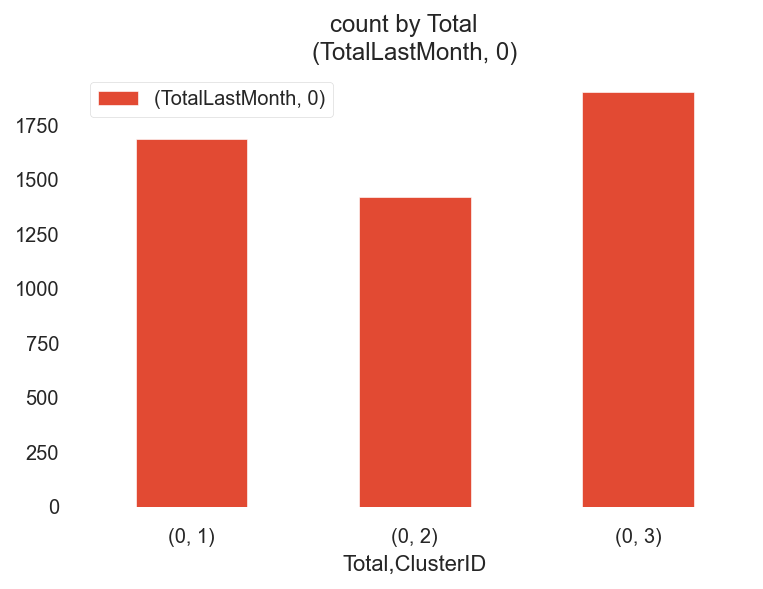

In [5]:
review_detail(df, 'LastMonth', 
              'Total', '', 
              'Total', 4, 
              'ClusterID', 'count', 
              True, 'total', True)

In [6]:
print('To the right is total customer sales'
      ' distribution \nby cluster: \n')
df_tot = df.groupby(['ClusterID'], ).agg({'TotalLastMonth':'sum'})
df_tot['pct_total'] = df_tot['TotalLastMonth'] / df_tot['TotalLastMonth'].sum()
df_tot = df_tot[['TotalLastMonth', 'pct_total']]
print(df_tot)

To the right is total customer sales distribution 
by cluster: 

           TotalLastMonth  pct_total
ClusterID                           
1                  109422   0.345490
2                   29993   0.094700
3                  177300   0.559809


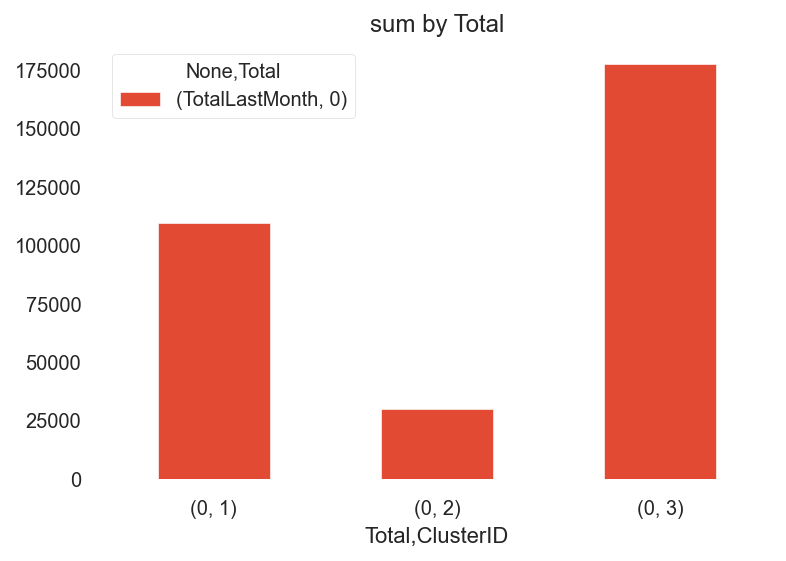

In [7]:
review_detail(df, 'LastMonth', 
              'Total', 1, 
              'Total', 1, 
              'ClusterID', 'sum', 
              False, 'total',False)

# Evaluate Segmentation Variables using Violin Plots

## PhoneCoTenure & Age

In [ ]:
sns.violinplot(x="ClusterID", y="PhoneCoTenure", 
               data=df, palette="Set2", 
               scale="count", inner="quartile")


In [ ]:
sns.violinplot(x="ClusterID", y="Age", data=df, 
               palette="Set2", scale="count", 
               inner="quartile")


## TotalServicesUsed & RevenueType

In [ ]:
sns.violinplot(x="ClusterID", y="TotalServicesUsed", 
               data=df, palette="Set2", 
               scale="count", inner="quartile")


In [ ]:
sns.violinplot(x="ClusterID", y="RevenueType", 
               data=df, palette="Set2", 
               scale="count", inner="quartile")




## DataLastMonth & EquipmentLastMonth

In [ ]:
sns.violinplot(x="ClusterID", y="DataLastMonth", 
               data=df, palette="Set2", 
               scale="count", inner="quartile")


In [ ]:
sns.violinplot(x="ClusterID", y="EquipmentLastMonth", 
               data=df, palette="Set2", 
               scale="count", inner="quartile")

## TotalLastMonth & VoiceLastMonth

In [ ]:
sns.violinplot(x="ClusterID", y="TotalLastMonth", 
               data=df, palette="Set2", 
               scale="count", inner="quartile")

In [ ]:
sns.violinplot(x="ClusterID", y="VoiceLastMonth", 
               data=df, palette="Set2", 
               scale="count", inner="quartile")

# Additional Review of Segmentation Outputs

## Review Total Sales and Customer Count Last Month

In [ ]:
df_revtype = df.groupby(['ClusterID'], ).agg({'TotalLastMonth':'sum','Total':'count'})
df_revtype.rename(columns={'Total':'TotalLastMonthCount'}, inplace=True)
df_revtype['pct_total'] = df_revtype['TotalLastMonth'] / df_revtype['TotalLastMonth'].sum()
df_revtype['pct_total_count'] = df_revtype['TotalLastMonthCount'] / df_revtype['TotalLastMonthCount'].sum()
df_revtype = df_revtype[['TotalLastMonth', 'pct_total', 'TotalLastMonthCount', 'pct_total_count']]
print(df_revtype['TotalLastMonth'].sum())
df_revtype

## Review Voice (only) Sales and Customer Count Last Month

In [ ]:
df_revtype = df.groupby(['ClusterID'], ).agg({'VoiceLastMonth':'sum','Total':'count'})
df_revtype.rename(columns={'Total':'TotalLastMonthCount'}, inplace=True)
df_revtype['pct_total'] = df_revtype['VoiceLastMonth'] / df_revtype['VoiceLastMonth'].sum()
df_revtype['pct_total_count'] = df_revtype['TotalLastMonthCount'] / df_revtype['TotalLastMonthCount'].sum()
df_revtype = df_revtype[['VoiceLastMonth', 'pct_total', 'TotalLastMonthCount', 'pct_total_count']]
print(df_revtype['VoiceLastMonth'].sum())
df_revtype

## Review Total Sales by Top 50% and Bottom 50% and Customer Count Last Month

In [ ]:
review_detail(df,'LastMonth',
              'Top50_Bottom50', '', 
              'ClusterID', "", 
              'Total', 'count', 
              True, 'total', False)

## Review Total Sales Last Month by Category (Data, Voice, & Equipment) by Cluster

In [ ]:
review_detail(df,'LastMonth',
              'Total', '', 
              'Total', '', 
              'ClusterID', 'sum', 
              False, 'else', False)

# Create individual datasets for each cluster & generate summary report

In [ ]:
df_1 = df.loc[df['ClusterID']==1]
print('df_1 shape:', df_1.shape)
df_2 = df.loc[df['ClusterID']==2]
print('df_2 shape:', df_2.shape)
df_3 = df.loc[df['ClusterID']==3]
print('df_3 shape:', df_3.shape)

In [ ]:
# #conda install -c conda-forge pandas-profiling -- use this code snippet on your command line to install pandas-profiling 
# #pandas_profiling provides a comprehensive report on the variables and various statistics around it.
# #It can be fairly overwhelming but is very useful
df_1_profile = df_1.profile_report(minimal=True)
df_1_profile.to_file(output_file="df_1 generated_report.html")
df_2_profile = df_2.profile_report(minimal=True)
df_2_profile.to_file(output_file="df_2 generated_report.html")
df_3_profile = df_3.profile_report(minimal=True)
df_3_profile.to_file(output_file="df_3 generated_report.html")

## See the additional attachments submitted with this report for generated reports